<a href="https://colab.research.google.com/github/the-cryptozoologist/geo/blob/main/GEE/GEE_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Earth Engine

In [ ]:
!pip install geemap

In [ ]:
import ee

ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=MUWEj7yRZd1vkm10gZzsk8slteSoyRcnWgkcViwwsiA&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjLJn_iPy18kp6nwFcjPXCZTX0bX_Fy9pYB5CEwxpDyawFRk-JBtrc

Successfully saved authorization token.


In [ ]:
import google.colab
import geemap.eefolium as geemap

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
countries = ee.FeatureCollection("FAO/GAUL/2015/level0").select("ADM0_NAME")

In [ ]:
Map = geemap.Map()

In [ ]:
peru = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq("ADM0_NAME", "Peru"))
Map.centerObject(peru, 4)
Map.addLayer(peru, {}, "SAM")
Map.addLayerControl()
Map

In [ ]:
Map = geemap.Map(center=[40,-100], zoom=4)

countries = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.inList("ADM0_NAME", ["Germany", "France", "Luxembourg", "Belgium", "Switzerland", "Netherlands"]))

Map.centerObject(countries, 4)
Map.addLayer(countries, {}, "Countries")

Map.addLayerControl()
Map

In [ ]:
names = countries.aggregate_array("ADM0_NAME").getInfo()
print(names)

['Netherlands', 'Luxembourg', 'France', 'Germany', 'Switzerland', 'Belgium']


In [ ]:
areas = countries.aggregate_array("Shape_Area").getInfo()
print(areas)

[4.63276492877, 0.327135974526, 64.4312552669, 45.8756542925, 4.86226314236, 3.89763866646]


<BarContainer object of 6 artists>

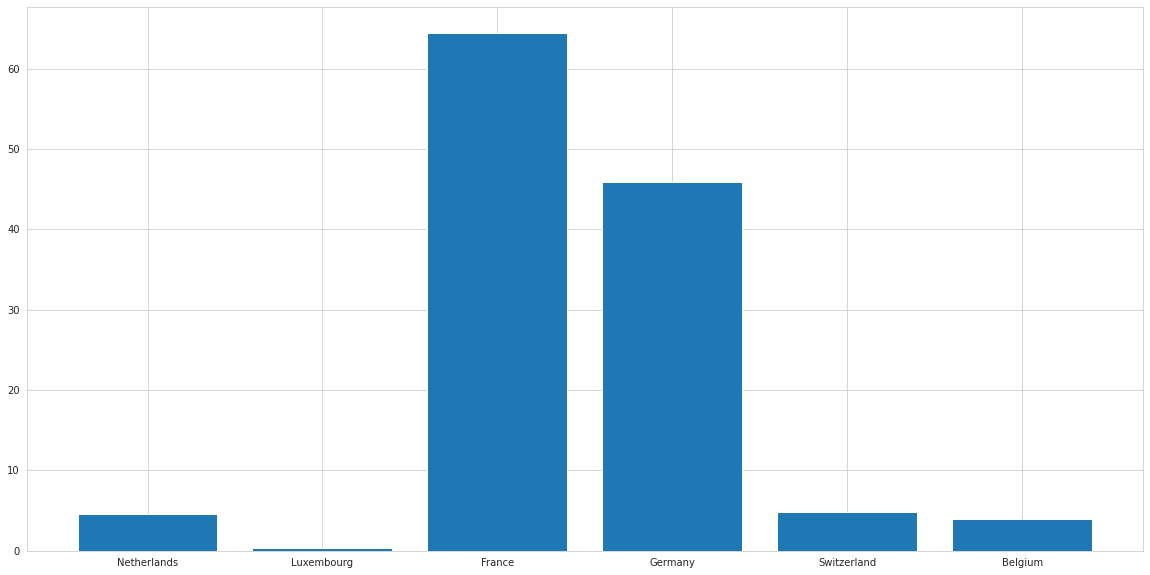

In [ ]:
plt.figure(figsize = [20,10])
plt.bar(names, areas)

# Numerical Data

In [ ]:
Map = geemap.Map(center=[40, -100], zoom=6)

khm = ee.FeatureCollection("WCMC/WDPA/current/polygons").filter(ee.Filter.eq("ISO3", "KHM"))

Map.centerObject(khm, 6)
Map.addLayer(khm, {}, "Cambodia PAs")
Map.addLayerControl()
Map

In [ ]:
print(f"Number of PAs: {khm.size().getInfo()}")

Number of PAs: 68


In [ ]:
population = khm.aggregate_sum("REP_AREA")

print(f"Total population: {population.getInfo()}")

Total population: 74644.81660999998


In [ ]:
big = khm.filter(ee.Filter.gt("GIS_AREA", 2600))

print(f"PA count - only larger PAs(Area > 2600): {big.size().getInfo()}")

PA count - only larger PAs(Area > 2600): 11


In [ ]:
Map = geemap.Map(center=[40, -100], zoom=6)

khm = ee.FeatureCollection("WCMC/WDPA/current/polygons").filter(ee.Filter.eq("ISO3", "KHM"))

big = khm.filter(ee.Filter.gt("GIS_AREA", 2600))

Map.centerObject(big, 6)
Map.addLayer(big, {}, "Cambodia PAs")
Map.addLayerControl()
Map

# Grouping by attribute

In [ ]:
#Protected areas

sums = khm.filter(ee.Filter.And(ee.Filter.neq("GIS_AREA", None),
                                ee.Filter.neq("STATUS_YR", None)))\
                                .reduceColumns(**{"selectors": ["GIS_AREA", "STATUS_YR", "NAME"],
                                                  "reducer": ee.Reducer.mean().repeat(2).group(**{
                                                      "groupField": 2,
                                                      "groupName": "PA"
                                                  })})
              
print(sums.getInfo())

{'groups': [{'PA': 'Ang Trapeng Thmor', 'mean': [126.987688809426, 2016]}, {'PA': 'Angkor', 'mean': [137.985502869213, 1993]}, {'PA': 'Anlong Pring', 'mean': [2.18663138373544, 2016]}, {'PA': 'Banteay Chhmar', 'mean': [850.955205186975, 1993]}, {'PA': 'Boeng Chhmar Core Area (Ramsar Site)', 'mean': [146.250437563593, 2000]}, {'PA': 'Boeng Lum Kud', 'mean': [1.11265142300564, 2018]}, {'PA': 'Boeng Paer', 'mean': [2508.39527946083, 1993]}, {'PA': 'Boeng Prek Lpov', 'mean': [83.4511761409677, 2016]}, {'PA': 'Boeng Prek Tub', 'mean': [0.163796004073936, 2016]}, {'PA': 'Boeng Yakaom Yakkara', 'mean': [1.32923958652482, 2020]}, {'PA': 'Boeng Yeak Laom', 'mean': [2.25957980767951, 2018]}, {'PA': 'Botum Sakor', 'mean': [1475.44559442819, 1993]}, {'PA': 'Cardamom Corridor', 'mean': [1701.63200922221, 2017]}, {'PA': 'Central Kravanh', 'mean': [4026.93874458258, 2016]}, {'PA': 'Chhaeb', 'mean': [1908.72737430326, 2016]}, {'PA': 'Dang Peaeng', 'mean': [286.952424977256, 1993]}, {'PA': 'Elettaria c

In [ ]:
#Marine protected areas CAT II & III

khm2 = khm.map(lambda f: f.set("MARINE", ee.Number.parse(f.get("MARINE"))))

sums2 = khm2.filter(ee.Filter.And(ee.Filter.neq("GIS_AREA", None),
                                  ee.Filter.neq("MARINE", None)))\
                                  .reduceColumns(**{"selectors": ["GIS_AREA", "MARINE", "IUCN_CAT"],
                                                    "reducer": ee.Reducer.mean().repeat(2).group(**{
                                                        "groupField": 2,
                                                        "groupName": "PA"
                                                    })})
                                  
print(sums2.getInfo())

{'groups': [{'PA': 'II', 'mean': [1433.682867147894, 0.08333333333333333]}, {'PA': 'III', 'mean': [123.98916919094721, 0]}, {'PA': 'IV', 'mean': [1890.2136121011818, 0.05263157894736842]}, {'PA': 'Ia', 'mean': [118.48793288663234, 0.16666666666666666]}, {'PA': 'V', 'mean': [141.31866243594425, 0.06666666666666667]}, {'PA': 'VI', 'mean': [1334.5498874559933, 0]}]}


# Clip shapefile

In [ ]:
Map = geemap.Map(center=[40,-100], zoom=4)

chf = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.inList("ADM0_NAME", ["Switzerland"]))

Map.centerObject(chf, 4)
Map.addLayer(chf, {}, "Switzerland")

Map.addLayerControl()
Map

In [ ]:
ELV = ee.Image("CSP/ERGo/1_0/Global/SRTM_CHILI")

In [ ]:
clipped_elv = ELV.clip(chf)
Map2 = geemap.Map(center=(40,-100), zoom=7)
Map2.add_basemap("SATELLITE")
Map2.centerObject(chf, 6)
Map2.addLayer(clipped_elv, {}, "Switzerland Elevation")
Map2.addLayerControl()
Map2

# GEE Image Collections

##Nighlights Image Collection

In [ ]:
Map = geemap.Map(center=[40,-100], zoom=4)

chf = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.inList("ADM0_NAME", ["Switzerland"]))

lights = ee.ImageCollection("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS")
Map.add_basemap("SATELLITE")
Map.centerObject(chf, 5)
Map.addLayer(lights, {}, "Nightlights")
Map.addLayerControl()
Map

## Image snippet from 1992

In [ ]:
Map = geemap.Map(center=[40,-100], zoom=4)


lights92 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F101992")
Map.add_basemap("SATELLITE")
Map.centerObject(chf, 5)
Map.addLayer(lights92.mask(lights92), {}, "DSMP-OLS 1992")
Map.addLayerControl()
Map

## Image snippet from 2012

In [ ]:
Map = geemap.Map(center=[40,-100], zoom=4)


lights12 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F182012")
Map.add_basemap("SATELLITE")
Map.centerObject(chf, 5)
Map.addLayer(lights12.mask(lights12), {}, "DSMP-OLS 2012")
Map.addLayerControl()
Map

## What changed?

In [ ]:
combo = geemap.Map(center=(40,-100), zoom=5)
combo.centerObject(chf, 5)

combo.add_basemap("SATELLITE")

tile92 = geemap.ee_tile_layer(lights92.mask(lights92), {}, "DMSP-OLS 92", opacity=0.75)
tile12 = geemap.ee_tile_layer(lights12.mask(lights12), {}, "DMSP-OLS 12", opacity=0.75)

combo.split_map(left_layer = tile92, right_layer = tile12)

combo

AttributeError: ignored

## Topography

In [ ]:
dem = ee.Image("USGS/SRTMGL1_003")

dem_vis = {
    "min": 0,
    "max": 4000,
    "palette": ["006633", "E5FFCC", "662A00", "D8D8D8", "F5F5F5"]
}

Map = geemap.Map(center=[0,0], zoom=1)

Map.addLayer(dem, dem_vis, "SRTM DEM")
Map

In [ ]:
slope = ee.Terrain.slope(dem).float()

aspect = ee.Terrain.aspect(dem).float()

new_terra = dem.addBands(slope).addBands(aspect)

print(new_terra)

ee.Image({
  "functionInvocationValue": {
    "functionName": "Image.addBands",
    "arguments": {
      "dstImg": {
        "functionInvocationValue": {
          "functionName": "Image.addBands",
          "arguments": {
            "dstImg": {
              "functionInvocationValue": {
                "functionName": "Image.load",
                "arguments": {
                  "id": {
                    "constantValue": "USGS/SRTMGL1_003"
                  }
                }
              }
            },
            "srcImg": {
              "functionInvocationValue": {
                "functionName": "Image.float",
                "arguments": {
                  "value": {
                    "functionInvocationValue": {
                      "functionName": "Terrain.slope",
                      "arguments": {
                        "input": {
                          "functionInvocationValue": {
                            "functionName": "Image.load",
                   

## Clip Image Collection to Shapefile

In [ ]:
modis = ee.ImageCollection("MODIS/006/MCD12Q1").select("LC_Type1")

modis_clp = modis.map(lambda x: x.clip(chf))

In [ ]:
igbpLandCoverVis = {
    "min": 1.0,
    "max": 17.0,
    "palette": ["05450a", "086a10", "78d203", "009900", "c6b044",
                "dcd159", "dade48", "fbff13", "b6ff05", "27ff87", "c24f44",
                "a5a5a5", "ff6d4c", "69fff8", "f9ffa4", "1c0dff"
    ]}

In [ ]:
Map = geemap.Map(center=[40,-100], zoom=4)

chf = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.inList("ADM0_NAME", ["Switzerland"]))

Map.add_basemap("SATELLITE")

Map.centerObject(chf, zoom=7)

Map.addLayer(modis_clp, igbpLandCoverVis, "MODIS Land Cover")

Map.addLayerControl()
Map.add_legend(builtin_legend= "MODIS/006/MCD12Q1")
Map

## Time Series  

In [ ]:
poly = ee.FeatureCollection("WCMC/WDPA/current/polygons")

pmk = poly.filter(ee.Filter.eq("NAME", "Hierapolis-Pamukkale"))

In [ ]:
modis = ee.ImageCollection("MODIS/006/MOD13Q1")
modis = modis.filterDate(ee.DateRange("2017-01-01", "2021-12-01"))
ndvi = modis.select("NDVI")

In [ ]:
def scale_factor(image):
  return image.multiply(0.0001).copyProperties(image, ["system:time_start"])

scaled_ndvi = ndvi.map(scale_factor)

In [ ]:
ndviCoverVis = {
    "min":0,
    "max":1,
    "palette": ["red","green","yellow"]
}

In [ ]:
Map = geemap.Map(center=[38.9637, 35.2433], zoom=5)
Map.centerObject(pmk, zoom=10)
Map.add_basemap("SATELLITE")
Map.addLayer(scaled_ndvi.mean().clip(pmk), ndviCoverVis, "NDVI")
Map.addLayer(pmk, {}, "PA")
Map.addLayerControl()
Map

In [ ]:
!pip install ipygee

     |████████████████████████████████| 129 kB 11.1 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
  Created wheel for ipygee: filename=ipygee-0.0.17-py3-none-any.whl size=40379 sha256=9090da72753ea59920fa8872509b631d8c366d7c9625174d1a28928aedb1b41c
  Stored in directory: /root/.cache/pip/wheels/73/af/7e/a9d3fac7d32e649c63fdbdb9b320181b20eb4bfdc80af13974
  Created wheel for geetools: filename=geetools-0.6.14-py3-none-any.whl size=92107 sha256=66b7dfae4c3e2b6944d2e20655c56359ae27c5baba2ee38ea8862f52c7790455
  Stored in directory: /root/.cache/pip/wheels/5c/55/29/0a09dcf6b39bba8c890e40171cac3e3607a5c4b354b7e9447c
Successfully built ipygee geetools


In [ ]:
!pip install -U proplot

     |████████████████████████████████| 8.0 MB 8.3 MB/s 


In [ ]:
!pip install geehydro

  Created wheel for geehydro: filename=geehydro-0.2.0-py2.py3-none-any.whl size=10143 sha256=2f6608e9c11fdd0c705325c01b1bed8c06c4077474a5b5fe5704a6d8245a0c5c
  Stored in directory: /root/.cache/pip/wheels/49/6c/92/019aeb37663078e6666afa9dd336e2d8df72d5683d7d357697
Successfully built geehydro


In [ ]:
import ee
import folium
import geehydro
import numpy as np
import pandas as pd
import proplot as pyplot
import matplotlib.pyplot as plt
from ipygee import*
from pandas.plotting import register_matplotlib_converters

/usr/local/lib/python3.7/dist-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


In [ ]:
pmk_ndvi = chart.Image.series(**{
    "imageCollection": scaled_ndvi,
    "region": pmk,
    "reducer": ee.Reducer.mean(),
    "scale": 1000,
    "xProperty": "system:time_start"
})

pmk_ndvi.renderWidget(width="50%")

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…